In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.calculate_proximity import calculate_peer_weights
from functions.calculate_monthly_returns import calculate_monthly_returns
from functions.load_datasets import load_datasets
from functions.load_datasets import organize_financial_data_by_year
from functions.load_datasets import sort_columns_chronologically
from functions.create_features import create_features

pd.set_option('future.no_silent_downcasting', True)

In [2]:
base = str(project_root) + "/data/"

config = {
    "df_sales": ("sales.xls", 1),
    "df_capital": ("capital.xls", 1),
    "df_cogs_ratio": ("cost.xls", 1),
    "df_sga_ratio": ("cost.xls", 2),
    "df_roic": ("roic.xls", 1),
    "df_rd_ratio": ("rd_profit.xls", 1),
    "df_opm": ("rd_profit.xls", 2),
    "df_roe": ("roe.xls", 1),
    "df_interest": ("interest_expenses.xls", 1),
}

dfs = {
    name: pd.read_excel(base + file, sheet_name=sheet).rename(columns={"Unnamed: 0": "Company"})
    for name, (file, sheet) in config.items()
}

years = list(range(2025, 2019, -1))
financial_dfs = organize_financial_data_by_year(dfs, years)
df_pbr, df_stp, df_mktcap = load_datasets(base)
df_returns = calculate_monthly_returns(df_stp)

In [3]:
def create_monthly_feature_data(financial_dfs, df_pbr_sorted):
    """
    各月ごとに利用可能な特徴量データを作成
    財務データは決算後3ヶ月（6月末）から利用可能とする
    """
    monthly_data = {}
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']

    for pbr_month in pbr_cols:
        year, month = int(pbr_month.split('/')[0]), int(pbr_month.split('/')[1])

        if month >= 7:
            available_fy = year
        else:
            available_fy = year - 1

        if available_fy not in financial_dfs:
            continue

        fin_df = financial_dfs[available_fy].copy()
        features_df = create_features(fin_df)

        pbr_data = df_pbr_sorted[['Company', pbr_month]].copy()
        pbr_data = pbr_data.rename(columns={pbr_month: 'PBR'})

        merged = features_df.merge(pbr_data, on='Company', how='inner')
        merged = merged.dropna()

        if len(merged) < 50:
            continue

        merged['log_pbr'] = np.log(merged['PBR'].clip(lower=0.01))
        merged = merged.set_index('Company')
        merged = merged.drop(columns=['PBR'])

        monthly_data[pbr_month] = merged

    return monthly_data

monthly_feature_data = create_monthly_feature_data(financial_dfs, df_pbr)
print(f"利用可能な月数: {len(monthly_feature_data)}")
print(f"期間: {min(monthly_feature_data.keys())} ～ {max(monthly_feature_data.keys())}")

利用可能な月数: 66
期間: 2020/07 ～ 2025/12


In [4]:
# ダブルソート戦略: PBR × MLシグナル
def create_double_sort_strategy(monthly_feature_data, df_pbr_sorted, df_returns,
                                 n_pbr_quintiles=5, n_ml_quintiles=5,
                                 lookback_months=12, top_k=10):
    """
    ダブルソート戦略: まずPBRで分位、次にMLシグナルで分位

    Parameters:
    -----------
    monthly_feature_data : dict
        月ごとの特徴量データ
    df_pbr_sorted : DataFrame
        PBRデータ
    df_returns : DataFrame
        月次リターンデータ
    n_pbr_quintiles : int
        PBRによる分位数
    n_ml_quintiles : int
        MLシグナルによる分位数
    lookback_months : int
        学習に使用する過去月数
    top_k : int
        類似企業の数

    Returns:
    --------
    DataFrame
        各ポートフォリオ（PBR分位×ML分位）の月次リターン
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    # 25個のポートフォリオ（5×5）
    portfolio_returns = {}
    for p in range(n_pbr_quintiles):
        for m in range(n_ml_quintiles):
            portfolio_returns[f'PBR{p+1}_ML{m+1}'] = []
    portfolio_returns['Date'] = []

    available_months = sorted([m for m in monthly_feature_data.keys()])

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]

        portfolio_returns['Date'].append(return_month.replace('ret_', ''))

        print(f"\n処理中: {formation_month} → {return_month.replace('ret_', '')}")

        # データが利用可能かチェック
        if formation_month not in monthly_feature_data:
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            print(f"  ⚠ {formation_month} のデータなし")
            continue

        current_df = monthly_feature_data[formation_month].copy()

        # 過去データを収集
        formation_idx = available_months.index(formation_month) if formation_month in available_months else -1
        if formation_idx < 0:
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            continue

        past_months = available_months[max(0, formation_idx - lookback_months):formation_idx]
        train_dfs = [monthly_feature_data[m] for m in past_months if m in monthly_feature_data]

        if len(train_dfs) == 0:
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            print(f"  ⚠ 学習データなし")
            continue

        train_df = pd.concat(train_dfs, axis=0)

        # 類似度計算
        try:
            weights_df = calculate_peer_weights(
                train_df=train_df,
                current_features_df=current_df,
                top_k=top_k,
                num_boost_round=100
            )
        except Exception as e:
            print(f"  ⚠ Proximity計算エラー: {e}")
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            continue

        if weights_df is None:
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            continue

        # PBRデータを取得
        pbr_series = df_pbr_sorted.set_index('Company')[formation_month]
        common_companies = weights_df.index.intersection(pbr_series.index)

        if len(common_companies) < n_pbr_quintiles * n_ml_quintiles:
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            continue

        # 類似企業の加重平均PBRを計算
        weights_subset = weights_df.loc[common_companies, common_companies]
        pbr_subset = pbr_series.loc[common_companies]

        peer_avg_pbr = weights_subset @ pbr_subset
        peer_avg_pbr = peer_avg_pbr.fillna(pbr_subset.mean())

        # MLシグナル: 相対PBR = 自社PBR / 類似企業平均PBR
        relative_pbr = pbr_subset / peer_avg_pbr

        # リターンデータを取得
        return_series = df_returns.set_index('Company')[return_month]

        # データをマージ
        temp_df = pd.DataFrame({
            'Company': common_companies,
            'PBR': pbr_subset.loc[common_companies].values,
            'ML_Signal': relative_pbr.loc[common_companies].values,
            'Return': return_series.reindex(common_companies).values
        })
        temp_df = temp_df.dropna()

        if len(temp_df) < n_pbr_quintiles * n_ml_quintiles * 2:
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            print(f"  ⚠ データ不足: {len(temp_df)}社")
            continue

        # Step 1: PBRで5分位に分割
        try:
            temp_df['PBR_Quintile'] = pd.qcut(temp_df['PBR'], q=n_pbr_quintiles, labels=False, duplicates='drop')
        except Exception as e:
            print(f"  ⚠ PBR分位分割エラー: {e}")
            for p in range(n_pbr_quintiles):
                for m in range(n_ml_quintiles):
                    portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(np.nan)
            continue

        # Step 2: 各PBR分位内でMLシグナルで5分位に分割
        temp_df['ML_Quintile'] = np.nan

        for pbr_q in range(n_pbr_quintiles):
            mask = temp_df['PBR_Quintile'] == pbr_q
            subset = temp_df.loc[mask, 'ML_Signal']

            if len(subset) >= n_ml_quintiles:
                try:
                    ml_quintiles = pd.qcut(subset, q=n_ml_quintiles, labels=False, duplicates='drop')
                    temp_df.loc[mask, 'ML_Quintile'] = ml_quintiles
                except:
                    # 分位分割できない場合はランクベースで分割
                    ranks = subset.rank(method='first')
                    temp_df.loc[mask, 'ML_Quintile'] = pd.cut(ranks, bins=n_ml_quintiles, labels=False)

        temp_df = temp_df.dropna(subset=['ML_Quintile'])
        temp_df['ML_Quintile'] = temp_df['ML_Quintile'].astype(int)

        # 各ポートフォリオのリターンを計算
        for p in range(n_pbr_quintiles):
            for m in range(n_ml_quintiles):
                mask = (temp_df['PBR_Quintile'] == p) & (temp_df['ML_Quintile'] == m)
                port_returns = temp_df.loc[mask, 'Return']
                avg_return = port_returns.mean() if len(port_returns) > 0 else np.nan
                portfolio_returns[f'PBR{p+1}_ML{m+1}'].append(avg_return)

        print(f"  ✓ 完了: {len(temp_df)}社")

    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# ダブルソート戦略を実行
print("=" * 80)
print("ダブルソート戦略（PBR × MLシグナル）の実行")
print("=" * 80)

double_sort_returns = create_double_sort_strategy(
    monthly_feature_data=monthly_feature_data,
    df_pbr_sorted=df_pbr,
    df_returns=df_returns,
    n_pbr_quintiles=5,
    n_ml_quintiles=5,
    lookback_months=12,
    top_k=10
)

print("\n" + "=" * 80)
print("ダブルソート戦略の構築完了")
print("=" * 80)
print(f"期間: {double_sort_returns.index[0]} ～ {double_sort_returns.index[-1]}")
print(f"観測数: {len(double_sort_returns)}")

ダブルソート戦略（PBR × MLシグナル）の実行

処理中: 2020/01 → 2020/02
  ⚠ 2020/01 のデータなし

処理中: 2020/02 → 2020/03
  ⚠ 2020/02 のデータなし

処理中: 2020/03 → 2020/04
  ⚠ 2020/03 のデータなし

処理中: 2020/04 → 2020/05
  ⚠ 2020/04 のデータなし

処理中: 2020/05 → 2020/06
  ⚠ 2020/05 のデータなし

処理中: 2020/06 → 2020/07
  ⚠ 2020/06 のデータなし

処理中: 2020/07 → 2020/08
  ⚠ 学習データなし

処理中: 2020/08 → 2020/09
corr: 0.9748, rmse: 0.2175
  ✓ 完了: 1447社

処理中: 2020/09 → 2020/10
corr: 0.9783, rmse: 0.2015
  ✓ 完了: 1447社

処理中: 2020/10 → 2020/11
corr: 0.9815, rmse: 0.1698
  ✓ 完了: 1448社

処理中: 2020/11 → 2020/12
corr: 0.9734, rmse: 0.2082
  ✓ 完了: 1448社

処理中: 2020/12 → 2021/01
corr: 0.9715, rmse: 0.2132
  ✓ 完了: 1446社

処理中: 2021/01 → 2021/02
corr: 0.9738, rmse: 0.2035
  ✓ 完了: 1446社

処理中: 2021/02 → 2021/03
corr: 0.9719, rmse: 0.2027
  ✓ 完了: 1446社

処理中: 2021/03 → 2021/04
corr: 0.9726, rmse: 0.2174
  ✓ 完了: 1446社

処理中: 2021/04 → 2021/05
corr: 0.9734, rmse: 0.1976
  ✓ 完了: 1446社

処理中: 2021/05 → 2021/06
corr: 0.9629, rmse: 0.2202
  ✓ 完了: 1448社

処理中: 2021/06 → 2021/07
corr: 

In [5]:
# PBRのみのダブルソート戦略（ベースライン比較用）
def create_double_sort_pbr_only(df_pbr_sorted, df_returns, n_pbr_quintiles=5, n_second_quintiles=5):
    """
    PBRのみのダブルソート戦略: まずPBRで分位、次にPBRで再度分位
    MLシグナルを使わないベースライン

    Parameters:
    -----------
    df_pbr_sorted : DataFrame
        PBRデータ
    df_returns : DataFrame
        月次リターンデータ
    n_pbr_quintiles : int
        1段階目のPBRによる分位数
    n_second_quintiles : int
        2段階目のPBRによる分位数

    Returns:
    --------
    DataFrame
        各ポートフォリオの月次リターン
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    # 25個のポートフォリオ（5×5）
    portfolio_returns = {}
    for p in range(n_pbr_quintiles):
        for s in range(n_second_quintiles):
            portfolio_returns[f'PBR{p+1}_PBR2nd{s+1}'] = []
    portfolio_returns['Date'] = []

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]

        portfolio_returns['Date'].append(return_month.replace('ret_', ''))

        # PBRデータを取得
        pbr_series = df_pbr_sorted.set_index('Company')[formation_month]
        return_series = df_returns.set_index('Company')[return_month]

        # データをマージ
        temp_df = pd.DataFrame({
            'Company': pbr_series.index,
            'PBR': pbr_series.values,
            'Return': return_series.reindex(pbr_series.index).values
        })
        temp_df = temp_df.dropna()

        if len(temp_df) < n_pbr_quintiles * n_second_quintiles * 2:
            for p in range(n_pbr_quintiles):
                for s in range(n_second_quintiles):
                    portfolio_returns[f'PBR{p+1}_PBR2nd{s+1}'].append(np.nan)
            continue

        # Step 1: PBRで5分位に分割
        try:
            temp_df['PBR_Quintile'] = pd.qcut(temp_df['PBR'], q=n_pbr_quintiles, labels=False, duplicates='drop')
        except:
            for p in range(n_pbr_quintiles):
                for s in range(n_second_quintiles):
                    portfolio_returns[f'PBR{p+1}_PBR2nd{s+1}'].append(np.nan)
            continue

        # Step 2: 各PBR分位内でPBRで再度5分位に分割
        temp_df['PBR_2nd_Quintile'] = np.nan

        for pbr_q in range(n_pbr_quintiles):
            mask = temp_df['PBR_Quintile'] == pbr_q
            subset = temp_df.loc[mask, 'PBR']

            if len(subset) >= n_second_quintiles:
                try:
                    second_quintiles = pd.qcut(subset, q=n_second_quintiles, labels=False, duplicates='drop')
                    temp_df.loc[mask, 'PBR_2nd_Quintile'] = second_quintiles
                except:
                    ranks = subset.rank(method='first')
                    temp_df.loc[mask, 'PBR_2nd_Quintile'] = pd.cut(ranks, bins=n_second_quintiles, labels=False)

        temp_df = temp_df.dropna(subset=['PBR_2nd_Quintile'])
        temp_df['PBR_2nd_Quintile'] = temp_df['PBR_2nd_Quintile'].astype(int)

        # 各ポートフォリオのリターンを計算
        for p in range(n_pbr_quintiles):
            for s in range(n_second_quintiles):
                mask = (temp_df['PBR_Quintile'] == p) & (temp_df['PBR_2nd_Quintile'] == s)
                port_returns = temp_df.loc[mask, 'Return']
                avg_return = port_returns.mean() if len(port_returns) > 0 else np.nan
                portfolio_returns[f'PBR{p+1}_PBR2nd{s+1}'].append(avg_return)

    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# PBRのみのダブルソート戦略を実行
print("=" * 80)
print("PBRのみのダブルソート戦略（ベースライン）の実行")
print("=" * 80)

double_sort_pbr_only = create_double_sort_pbr_only(
    df_pbr_sorted=df_pbr,
    df_returns=df_returns,
    n_pbr_quintiles=5,
    n_second_quintiles=5
)

print(f"期間: {double_sort_pbr_only.index[0]} ～ {double_sort_pbr_only.index[-1]}")
print(f"観測数: {len(double_sort_pbr_only)}")
print("=" * 80)

PBRのみのダブルソート戦略（ベースライン）の実行
期間: 2020/02 ～ 2025/12
観測数: 71


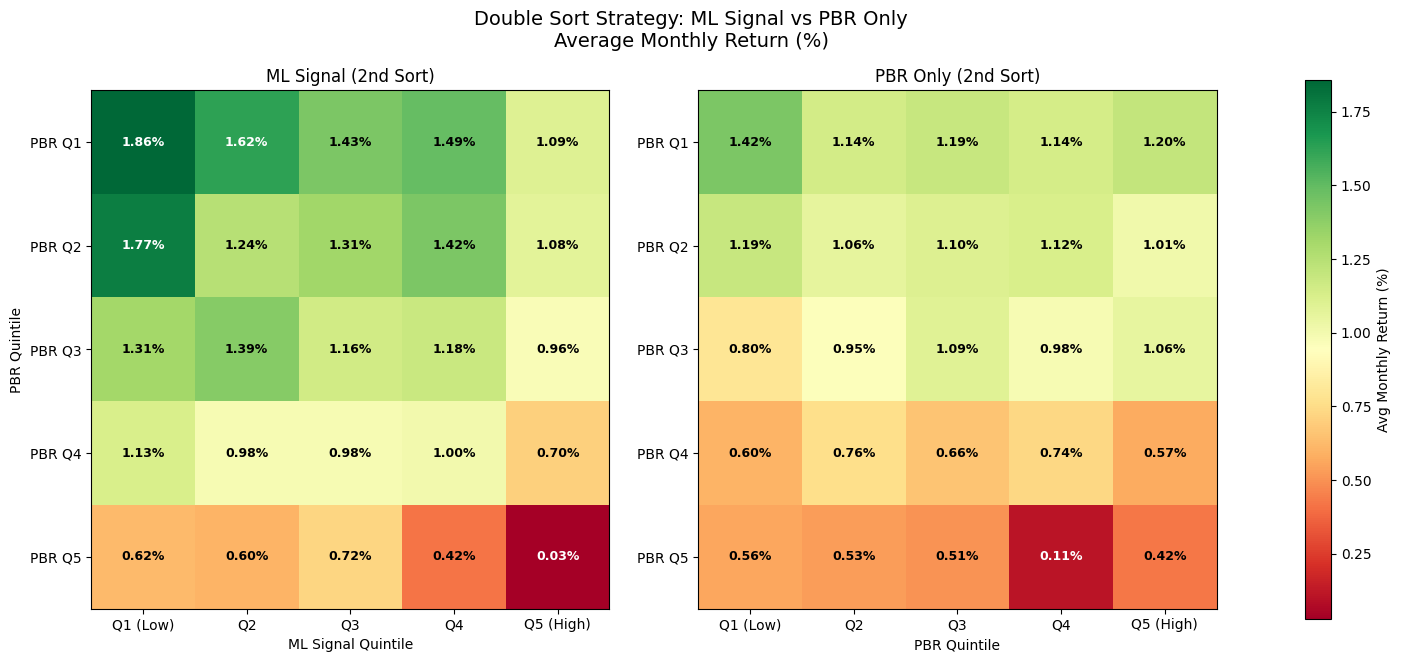


平均月次リターン（%）の比較

【MLシグナル版】
        ML_Q1  ML_Q2  ML_Q3  ML_Q4  ML_Q5
PBR_Q1  1.858  1.624  1.427  1.490  1.095
PBR_Q2  1.769  1.244  1.315  1.422  1.078
PBR_Q3  1.309  1.394  1.156  1.185  0.965
PBR_Q4  1.128  0.985  0.979  1.000  0.701
PBR_Q5  0.623  0.604  0.724  0.417  0.028

【PBRのみ版】
        PBR2nd_Q1  PBR2nd_Q2  PBR2nd_Q3  PBR2nd_Q4  PBR2nd_Q5
PBR_Q1      1.424      1.144      1.190      1.142      1.203
PBR_Q2      1.190      1.062      1.105      1.123      1.009
PBR_Q3      0.800      0.952      1.092      0.979      1.057
PBR_Q4      0.605      0.761      0.664      0.735      0.573
PBR_Q5      0.564      0.532      0.507      0.112      0.424


In [32]:
from matplotlib import gridspec

# ============================
# 図のレイアウト（3列: ML | PBR | Colorbar）
# ============================
fig = plt.figure(figsize=(16, 7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.25)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])   # colorbar専用

# ============================
# データ作成（そのまま）
# ============================
common_dates = double_sort_returns.index.intersection(double_sort_pbr_only.index)
ml_returns_common = double_sort_returns.loc[common_dates]
pbr_returns_common = double_sort_pbr_only.loc[common_dates]

mean_returns_ml = ml_returns_common.mean()
mean_returns_pbr = pbr_returns_common.mean()

heatmap_ml = np.zeros((5, 5))
heatmap_pbr = np.zeros((5, 5))

for p in range(5):
    for m in range(5):
        heatmap_ml[p, m] = mean_returns_ml[f'PBR{p+1}_ML{m+1}'] * 100
    for s in range(5):
        heatmap_pbr[p, s] = mean_returns_pbr[f'PBR{p+1}_PBR2nd{s+1}'] * 100

vmin = min(heatmap_ml.min(), heatmap_pbr.min())
vmax = max(heatmap_ml.max(), heatmap_pbr.max())

# ============================
# Heatmap 描画
# ============================
im1 = ax1.imshow(heatmap_ml, cmap="RdYlGn", vmin=vmin, vmax=vmax)
im2 = ax2.imshow(heatmap_pbr, cmap="RdYlGn", vmin=vmin, vmax=vmax)

# 軸ラベル
labels = ['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)']
pbr_labels = ['PBR Q1', 'PBR Q2', 'PBR Q3', 'PBR Q4', 'PBR Q5']

ax1.set_xticks(range(5)); ax2.set_xticks(range(5))
ax1.set_yticks(range(5)); ax2.set_yticks(range(5))
ax1.set_xticklabels(labels); ax2.set_xticklabels(labels)
ax1.set_yticklabels(pbr_labels); ax2.set_yticklabels(pbr_labels)

ax1.set_title("ML Signal (2nd Sort)")
ax2.set_title("PBR Only (2nd Sort)")
ax1.set_xlabel("ML Signal Quintile")
ax2.set_xlabel("PBR Quintile")
ax1.set_ylabel("PBR Quintile")

# ============================
# 数値の書き込み
# ============================
def annotate(ax, data):
    for i in range(5):
        for j in range(5):
            val = data[i, j]
            color = "white" if abs(val - (vmin+vmax)/2) > (vmax-vmin)/3 else "black"
            ax.text(j, i, f"{val:.2f}%", ha="center", va="center",
                    fontsize=9, fontweight="bold", color=color)

annotate(ax1, heatmap_ml)
annotate(ax2, heatmap_pbr)

# ============================
# Colorbar
# ============================
fig.colorbar(im2, cax=cax, label="Avg Monthly Return (%)")

# ============================
# タイトル
# ============================
fig.suptitle("Double Sort Strategy: ML Signal vs PBR Only\nAverage Monthly Return (%)", fontsize=14)

plt.show()

# ============================
# 統計サマリー（そのまま）
# ============================
print("\n" + "=" * 80)
print("平均月次リターン（%）の比較")
print("=" * 80)
print("\n【MLシグナル版】")
print(pd.DataFrame(heatmap_ml,
    index=[f'PBR_Q{i+1}' for i in range(5)],
    columns=[f'ML_Q{i+1}' for i in range(5)]
).round(3))

print("\n【PBRのみ版】")
print(pd.DataFrame(heatmap_pbr,
    index=[f'PBR_Q{i+1}' for i in range(5)],
    columns=[f'PBR2nd_Q{i+1}' for i in range(5)]
).round(3))


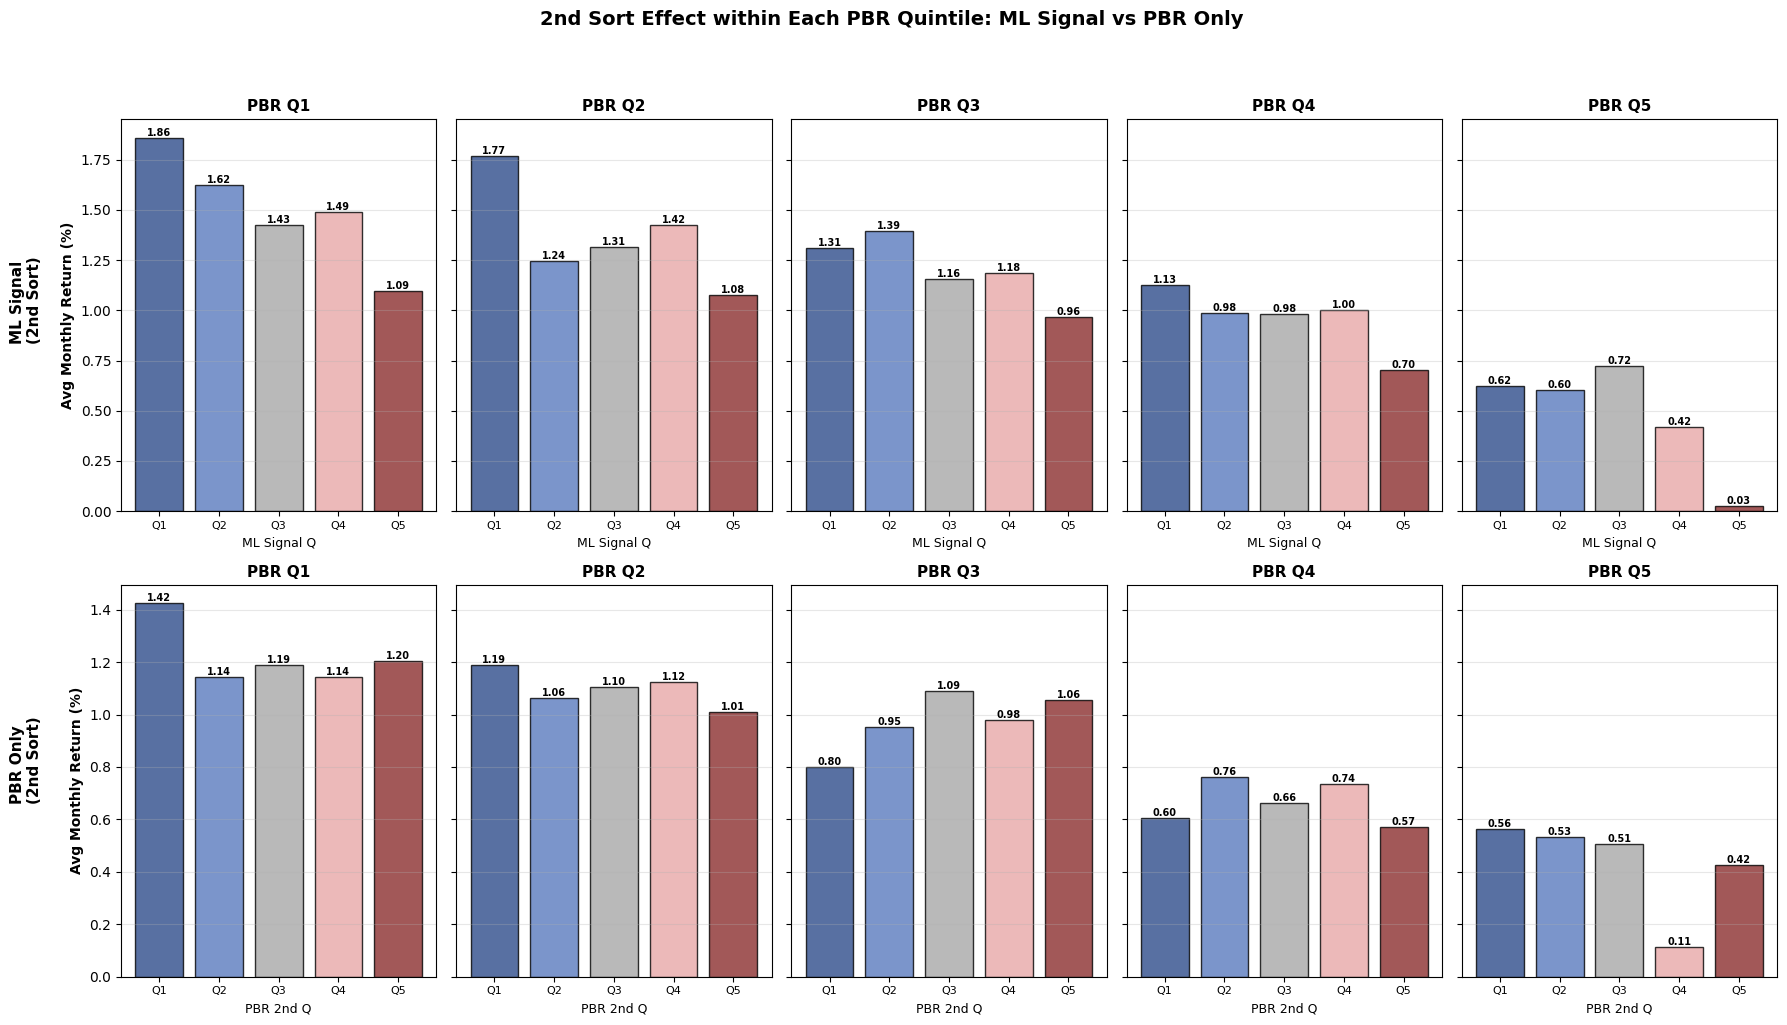

In [7]:
# 図2: 各PBR分位内での2段階目ソート効果の比較（ML vs PBRのみ）
fig, axes = plt.subplots(2, 5, figsize=(18, 10), sharey='row')

colors = ['#2E4C8B', '#5A7BBF', '#A8A8A8', '#E8A8A8', '#8B2E2E']

# 上段: MLシグナル版
for p in range(5):
    ax = axes[0, p]
    ml_returns = [mean_returns_ml[f'PBR{p+1}_ML{m+1}'] * 100 for m in range(5)]

    bars = ax.bar(range(5), ml_returns, color=colors, edgecolor='black', alpha=0.8)

    ax.set_xlabel('ML Signal Q', fontsize=9)
    ax.set_title(f'PBR Q{p+1}', fontsize=11, fontweight='bold')
    ax.set_xticks(range(5))
    ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], fontsize=8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='y')

    for bar, val in zip(bars, ml_returns):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
               f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=7, fontweight='bold')

axes[0, 0].set_ylabel('Avg Monthly Return (%)', fontsize=10, fontweight='bold')

# 下段: PBRのみ版
for p in range(5):
    ax = axes[1, p]
    pbr_returns = [mean_returns_pbr[f'PBR{p+1}_PBR2nd{s+1}'] * 100 for s in range(5)]

    bars = ax.bar(range(5), pbr_returns, color=colors, edgecolor='black', alpha=0.8)

    ax.set_xlabel('PBR 2nd Q', fontsize=9)
    ax.set_title(f'PBR Q{p+1}', fontsize=11, fontweight='bold')
    ax.set_xticks(range(5))
    ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], fontsize=8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='y')

    for bar, val in zip(bars, pbr_returns):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
               f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=7, fontweight='bold')

axes[1, 0].set_ylabel('Avg Monthly Return (%)', fontsize=10, fontweight='bold')

# 行ラベル
fig.text(0.01, 0.73, 'ML Signal\n(2nd Sort)', fontsize=11, fontweight='bold',
         ha='left', va='center', rotation=90)
fig.text(0.01, 0.27, 'PBR Only\n(2nd Sort)', fontsize=11, fontweight='bold',
         ha='left', va='center', rotation=90)

fig.suptitle('2nd Sort Effect within Each PBR Quintile: ML Signal vs PBR Only',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0.03, 0, 1, 0.98])
plt.show()

各PBR分位内での2段階目プレミアム（Q1 - Q5）の統計分析

【MLシグナルプレミアム（ML_Q1 - ML_Q5）】
------------------------------------------------------------
PBR_Q1: 平均=0.763%, t=3.006, p=0.0038 ***
PBR_Q2: 平均=0.691%, t=3.201, p=0.0021 ***
PBR_Q3: 平均=0.345%, t=1.702, p=0.0936 *
PBR_Q4: 平均=0.427%, t=1.572, p=0.1209 
PBR_Q5: 平均=0.594%, t=1.201, p=0.2343 

【PBRのみプレミアム（PBR2nd_Q1 - PBR2nd_Q5）】
------------------------------------------------------------
PBR_Q1: 平均=0.221%, t=1.226, p=0.2245 
PBR_Q2: 平均=0.181%, t=1.353, p=0.1804 
PBR_Q3: 平均=-0.257%, t=-1.744, p=0.0856 *
PBR_Q4: 平均=0.032%, t=0.142, p=0.8875 
PBR_Q5: 平均=0.140%, t=0.356, p=0.7226 

注: *** p<0.01, ** p<0.05, * p<0.1


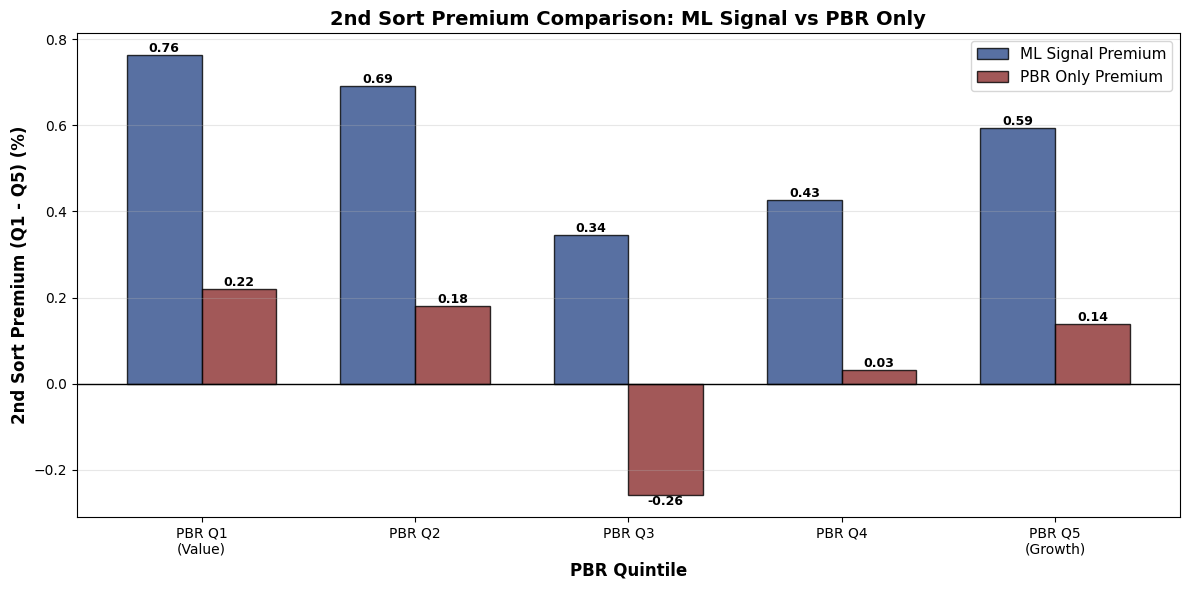

In [8]:
# 図3: 各PBR分位内での2段階目プレミアム比較（Q1 - Q5）
# MLプレミアム（ML_Q1 - ML_Q5）
ml_premiums = {}
for p in range(5):
    ml_q1 = ml_returns_common[f'PBR{p+1}_ML1']
    ml_q5 = ml_returns_common[f'PBR{p+1}_ML5']
    ml_premiums[f'PBR_Q{p+1}'] = ml_q1 - ml_q5

ml_premium_df = pd.DataFrame(ml_premiums)

# PBRプレミアム（PBR2nd_Q1 - PBR2nd_Q5）
pbr_premiums = {}
for p in range(5):
    pbr_q1 = pbr_returns_common[f'PBR{p+1}_PBR2nd1']
    pbr_q5 = pbr_returns_common[f'PBR{p+1}_PBR2nd5']
    pbr_premiums[f'PBR_Q{p+1}'] = pbr_q1 - pbr_q5

pbr_premium_df = pd.DataFrame(pbr_premiums)

# 統計分析
print("=" * 80)
print("各PBR分位内での2段階目プレミアム（Q1 - Q5）の統計分析")
print("=" * 80)

print("\n【MLシグナルプレミアム（ML_Q1 - ML_Q5）】")
print("-" * 60)
ml_results = []
for col in ml_premium_df.columns:
    premium = ml_premium_df[col].dropna()
    mean_prem = premium.mean()
    std_prem = premium.std()
    t_stat = mean_prem / (std_prem / np.sqrt(len(premium)))
    _, p_val = stats.ttest_1samp(premium, 0)
    sig = '***' if p_val < 0.01 else ('**' if p_val < 0.05 else ('*' if p_val < 0.1 else ''))
    ml_results.append({'PBR分位': col, '平均': mean_prem*100, 't値': t_stat, 'p値': p_val, '有意性': sig})
    print(f"{col}: 平均={mean_prem*100:.3f}%, t={t_stat:.3f}, p={p_val:.4f} {sig}")

print("\n【PBRのみプレミアム（PBR2nd_Q1 - PBR2nd_Q5）】")
print("-" * 60)
pbr_results = []
for col in pbr_premium_df.columns:
    premium = pbr_premium_df[col].dropna()
    mean_prem = premium.mean()
    std_prem = premium.std()
    t_stat = mean_prem / (std_prem / np.sqrt(len(premium)))
    _, p_val = stats.ttest_1samp(premium, 0)
    sig = '***' if p_val < 0.01 else ('**' if p_val < 0.05 else ('*' if p_val < 0.1 else ''))
    pbr_results.append({'PBR分位': col, '平均': mean_prem*100, 't値': t_stat, 'p値': p_val, '有意性': sig})
    print(f"{col}: 平均={mean_prem*100:.3f}%, t={t_stat:.3f}, p={p_val:.4f} {sig}")

print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

# 比較棒グラフ
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(5)
width = 0.35

ml_means = [ml_premium_df[col].mean() * 100 for col in ml_premium_df.columns]
pbr_means = [pbr_premium_df[col].mean() * 100 for col in pbr_premium_df.columns]

bars1 = ax.bar(x - width/2, ml_means, width, label='ML Signal Premium', color='#2E4C8B', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, pbr_means, width, label='PBR Only Premium', color='#8B2E2E', edgecolor='black', alpha=0.8)

ax.set_xlabel('PBR Quintile', fontsize=12, fontweight='bold')
ax.set_ylabel('2nd Sort Premium (Q1 - Q5) (%)', fontsize=12, fontweight='bold')
ax.set_title('2nd Sort Premium Comparison: ML Signal vs PBR Only', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['PBR Q1\n(Value)', 'PBR Q2', 'PBR Q3', 'PBR Q4', 'PBR Q5\n(Growth)'])
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# 値を表示
for bar, val in zip(bars1, ml_means):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, pbr_means):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [33]:
# 全PBR分位を通じた平均プレミアム比較
avg_ml_premium = ml_premium_df.mean(axis=1)
avg_pbr_premium = pbr_premium_df.mean(axis=1)

print("=" * 80)
print("全PBR分位を通じた平均プレミアムの統計分析")
print("=" * 80)

# MLシグナルプレミアム
print("\n【MLシグナルプレミアム】")
print("-" * 60)
mean_prem_ml = avg_ml_premium.mean()
std_prem_ml = avg_ml_premium.std()
t_stat_ml = mean_prem_ml / (std_prem_ml / np.sqrt(len(avg_ml_premium.dropna())))
_, p_val_ml = stats.ttest_1samp(avg_ml_premium.dropna(), 0)
sig_ml = '***' if p_val_ml < 0.01 else ('**' if p_val_ml < 0.05 else ('*' if p_val_ml < 0.1 else ''))

print(f"平均月次プレミアム: {mean_prem_ml*100:.4f}%")
print(f"年率プレミアム: {mean_prem_ml*12*100:.2f}%")
print(f"標準偏差: {std_prem_ml*100:.4f}%")
print(f"t値: {t_stat_ml:.4f}")
print(f"p値: {p_val_ml:.6f}")
print(f"有意性: {sig_ml} ({'有意' if sig_ml else '有意でない'})")

# PBRのみプレミアム
print("\n【PBRのみプレミアム】")
print("-" * 60)
mean_prem_pbr = avg_pbr_premium.mean()
std_prem_pbr = avg_pbr_premium.std()
t_stat_pbr = mean_prem_pbr / (std_prem_pbr / np.sqrt(len(avg_pbr_premium.dropna())))
_, p_val_pbr = stats.ttest_1samp(avg_pbr_premium.dropna(), 0)
sig_pbr = '***' if p_val_pbr < 0.01 else ('**' if p_val_pbr < 0.05 else ('*' if p_val_pbr < 0.1 else ''))

print(f"平均月次プレミアム: {mean_prem_pbr*100:.4f}%")
print(f"年率プレミアム: {mean_prem_pbr*12*100:.2f}%")
print(f"標準偏差: {std_prem_pbr*100:.4f}%")
print(f"t値: {t_stat_pbr:.4f}")
print(f"p値: {p_val_pbr:.6f}")
print(f"有意性: {sig_pbr} ({'有意' if sig_pbr else '有意でない'})")

# 比較サマリー
print("\n" + "=" * 80)
print("比較サマリー")
print("=" * 80)
comparison_data = {
    '指標': ['平均月次プレミアム', '年率プレミアム', 't値', 'p値', '有意性', '勝率'],
    'MLシグナル': [f'{mean_prem_ml*100:.3f}%', f'{mean_prem_ml*12*100:.2f}%',
                   f'{t_stat_ml:.3f}', f'{p_val_ml:.4f}', sig_ml,
                   f'{(avg_ml_premium > 0).sum() / len(avg_ml_premium.dropna()) * 100:.1f}%'],
    'PBRのみ': [f'{mean_prem_pbr*100:.3f}%', f'{mean_prem_pbr*12*100:.2f}%',
                f'{t_stat_pbr:.3f}', f'{p_val_pbr:.4f}', sig_pbr,
                f'{(avg_pbr_premium > 0).sum() / len(avg_pbr_premium.dropna()) * 100:.1f}%']
}
print(pd.DataFrame(comparison_data).to_string(index=False))
print("=" * 80)

全PBR分位を通じた平均プレミアムの統計分析

【MLシグナルプレミアム】
------------------------------------------------------------
平均月次プレミアム: 0.5639%
年率プレミアム: 6.77%
標準偏差: 1.2123%
t値: 3.7211
p値: 0.000425
有意性: *** (有意)

【PBRのみプレミアム】
------------------------------------------------------------
平均月次プレミアム: 0.0632%
年率プレミアム: 0.76%
標準偏差: 1.2528%
t値: 0.4249
p値: 0.672233
有意性:  (有意でない)

比較サマリー
       指標 MLシグナル  PBRのみ
平均月次プレミアム 0.564% 0.063%
  年率プレミアム  6.77%  0.76%
       t値  3.721  0.425
       p値 0.0004 0.6722
      有意性    ***       
       勝率  68.8%  50.7%


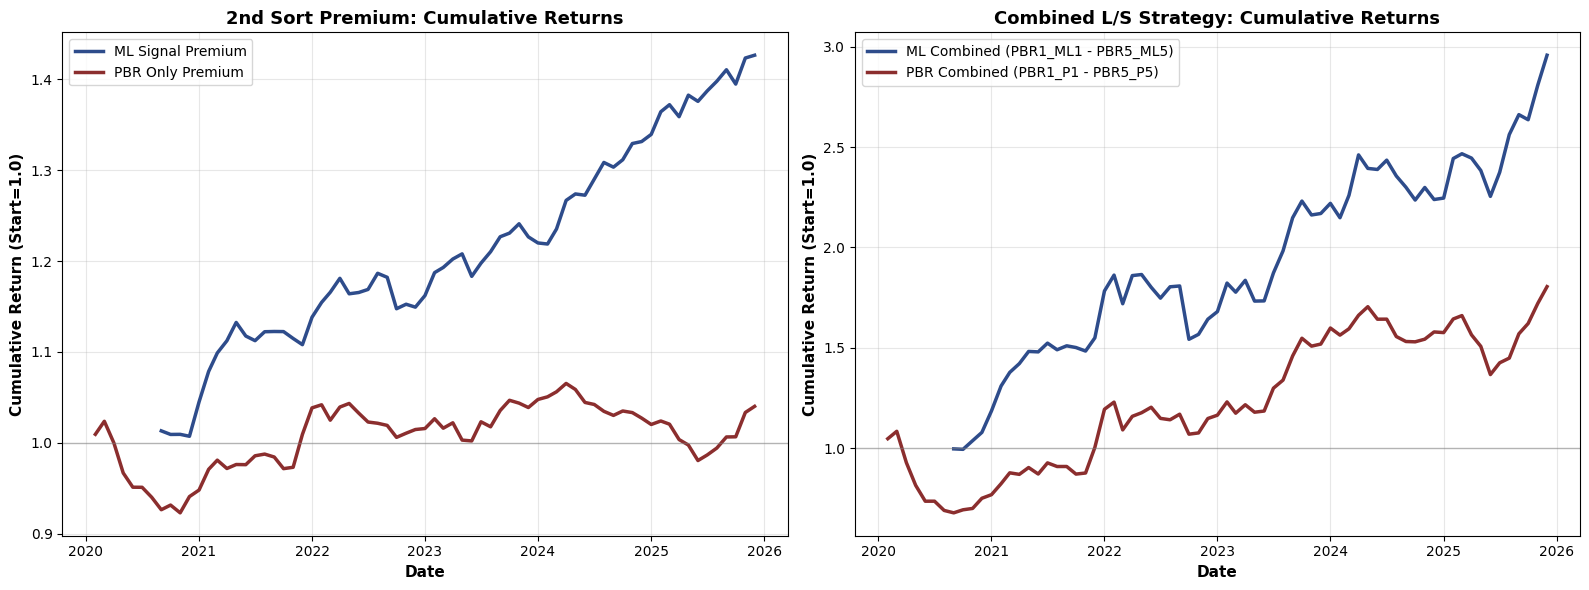


最終累積リターン

【2段階目プレミアム（全PBR分位平均）】
MLシグナル: 1.4266 (+42.66%)
PBRのみ: 1.0401 (+4.01%)

【複合戦略（極端なポートフォリオ間）】
ML Combined: 2.9580 (+195.80%)
PBR Combined: 1.8049 (+80.49%)


In [10]:
# 図4: Long-Short戦略の累積リターン比較（ML vs PBRのみ）
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 共通の日付
dates = pd.to_datetime(common_dates, format='%Y/%m')

# 左: 2段階目プレミアムの累積リターン
ax1 = axes[0]
cum_ml_premium = (1 + avg_ml_premium.loc[common_dates]).cumprod()
cum_pbr_premium = (1 + avg_pbr_premium.loc[common_dates]).cumprod()

ax1.plot(dates, cum_ml_premium, linewidth=2.5, color='#2E4C8B', label='ML Signal Premium')
ax1.plot(dates, cum_pbr_premium, linewidth=2.5, color='#8B2E2E', label='PBR Only Premium')

ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('Cumulative Return (Start=1.0)', fontsize=11, fontweight='bold')
ax1.set_title('2nd Sort Premium: Cumulative Returns', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

# 右: 複合戦略の累積リターン
ax2 = axes[1]

# ML複合: PBR1_ML1 - PBR5_ML5
ml_combined = ml_returns_common['PBR1_ML1'] - ml_returns_common['PBR5_ML5']
cum_ml_combined = (1 + ml_combined).cumprod()

# PBR複合: PBR1_PBR2nd1 - PBR5_PBR2nd5
pbr_combined = pbr_returns_common['PBR1_PBR2nd1'] - pbr_returns_common['PBR5_PBR2nd5']
cum_pbr_combined = (1 + pbr_combined).cumprod()

ax2.plot(dates, cum_ml_combined, linewidth=2.5, color='#2E4C8B', label='ML Combined (PBR1_ML1 - PBR5_ML5)')
ax2.plot(dates, cum_pbr_combined, linewidth=2.5, color='#8B2E2E', label='PBR Combined (PBR1_P1 - PBR5_P5)')

ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative Return (Start=1.0)', fontsize=11, fontweight='bold')
ax2.set_title('Combined L/S Strategy: Cumulative Returns', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターン
print("\n" + "=" * 80)
print("最終累積リターン")
print("=" * 80)
print("\n【2段階目プレミアム（全PBR分位平均）】")
print(f"MLシグナル: {cum_ml_premium.iloc[-1]:.4f} ({(cum_ml_premium.iloc[-1]-1)*100:+.2f}%)")
print(f"PBRのみ: {cum_pbr_premium.iloc[-1]:.4f} ({(cum_pbr_premium.iloc[-1]-1)*100:+.2f}%)")

print("\n【複合戦略（極端なポートフォリオ間）】")
print(f"ML Combined: {cum_ml_combined.iloc[-1]:.4f} ({(cum_ml_combined.iloc[-1]-1)*100:+.2f}%)")
print(f"PBR Combined: {cum_pbr_combined.iloc[-1]:.4f} ({(cum_pbr_combined.iloc[-1]-1)*100:+.2f}%)")
print("=" * 80)

シャープレシオ比較: MLシグナル vs PBRのみ
                  戦略 平均月次リターン   標準偏差 月次シャープ 年率シャープ
 ML 2nd Sort Premium   0.564% 1.212%  0.465  1.611
PBR 2nd Sort Premium   0.063% 1.253%  0.050  0.175
     ML Combined L/S   1.829% 4.957%  0.369  1.278
    PBR Combined L/S   0.999% 5.773%  0.173  0.600


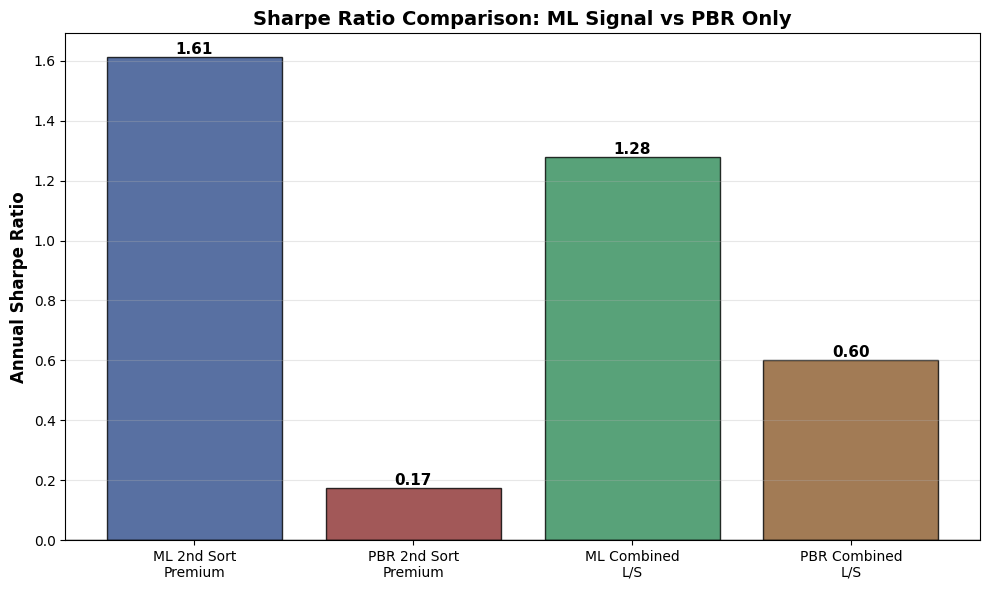

In [11]:
# シャープレシオの比較
print("=" * 80)
print("シャープレシオ比較: MLシグナル vs PBRのみ")
print("=" * 80)

strategies = {
    'ML 2nd Sort Premium': avg_ml_premium.loc[common_dates],
    'PBR 2nd Sort Premium': avg_pbr_premium.loc[common_dates],
    'ML Combined L/S': ml_combined,
    'PBR Combined L/S': pbr_combined
}

sharpe_results = []
for name, returns in strategies.items():
    returns = returns.dropna()
    mean_ret = returns.mean()
    std_ret = returns.std()
    sharpe_monthly = mean_ret / std_ret if std_ret > 0 else 0
    sharpe_annual = sharpe_monthly * np.sqrt(12)

    sharpe_results.append({
        '戦略': name,
        '平均月次リターン': f'{mean_ret*100:.3f}%',
        '標準偏差': f'{std_ret*100:.3f}%',
        '月次シャープ': f'{sharpe_monthly:.3f}',
        '年率シャープ': f'{sharpe_annual:.3f}'
    })

sharpe_df = pd.DataFrame(sharpe_results)
print(sharpe_df.to_string(index=False))
print("=" * 80)

# 棒グラフでシャープレシオを比較
fig, ax = plt.subplots(figsize=(10, 6))

strategy_names = ['ML 2nd Sort\nPremium', 'PBR 2nd Sort\nPremium', 'ML Combined\nL/S', 'PBR Combined\nL/S']
sharpe_values = [float(r['年率シャープ']) for r in sharpe_results]
colors = ['#2E4C8B', '#8B2E2E', '#2E8B57', '#8B5A2B']

bars = ax.bar(range(4), sharpe_values, color=colors, edgecolor='black', alpha=0.8)
ax.set_xticks(range(4))
ax.set_xticklabels(strategy_names, fontsize=10)
ax.set_ylabel('Annual Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Sharpe Ratio Comparison: ML Signal vs PBR Only', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, sharpe_values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [12]:
# 結論サマリー
print("\n" + "=" * 80)
print("ダブルソート戦略の結論: MLシグナル vs PBRのみ")
print("=" * 80)
print("""
【分析手法】
1. まずPBRで全銘柄を5分位に分割（PBR_Q1=バリュー、PBR_Q5=グロース）
2. 各PBR分位内で2段階目のソートを実施:
   - MLシグナル版: 類似企業平均PBRに対する相対PBRで5分位に分割
   - PBRのみ版: 同じPBRで再度5分位に分割（ベースライン）
3. 合計25個のポートフォリオ（5×5）を構築

【比較のポイント】
- MLシグナル: LightGBMで類似企業を特定し、その平均PBRとの相対値を使用
- PBRのみ: 追加情報なしで単純にPBRを細分化

【検証内容】
- PBRをコントロールした上でMLシグナルに追加的な情報価値があるか
- 各PBR分位内で2段階目プレミアム（Q1 - Q5）の大きさと有意性を比較
- シャープレシオでリスク調整後のパフォーマンスを比較

【結果の解釈】
- MLシグナルがPBRのみより優れている場合:
  → 類似企業との比較が追加的な情報を持つ（MLの有効性あり）
- 両者が同程度の場合:
  → MLシグナルはPBRを細分化しているだけで追加的価値なし
- PBRのみが優れている場合:
  → MLによるノイズが増加している可能性
""")


ダブルソート戦略の結論: MLシグナル vs PBRのみ

【分析手法】
1. まずPBRで全銘柄を5分位に分割（PBR_Q1=バリュー、PBR_Q5=グロース）
2. 各PBR分位内で2段階目のソートを実施:
   - MLシグナル版: 類似企業平均PBRに対する相対PBRで5分位に分割
   - PBRのみ版: 同じPBRで再度5分位に分割（ベースライン）
3. 合計25個のポートフォリオ（5×5）を構築

【比較のポイント】
- MLシグナル: LightGBMで類似企業を特定し、その平均PBRとの相対値を使用
- PBRのみ: 追加情報なしで単純にPBRを細分化

【検証内容】
- PBRをコントロールした上でMLシグナルに追加的な情報価値があるか
- 各PBR分位内で2段階目プレミアム（Q1 - Q5）の大きさと有意性を比較
- シャープレシオでリスク調整後のパフォーマンスを比較

【結果の解釈】
- MLシグナルがPBRのみより優れている場合:
  → 類似企業との比較が追加的な情報を持つ（MLの有効性あり）
- 両者が同程度の場合:
  → MLシグナルはPBRを細分化しているだけで追加的価値なし
- PBRのみが優れている場合:
  → MLによるノイズが増加している可能性

